# **Preparation**

## Import library

In [4]:
# !pip install -q opencv-python

In [6]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import math
import numpy.linalg as LA

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Code to run pose estimation using MoveNet

In [ ]:
# # Download model from TF Hub and check out inference code from GitHub
# # Model movenet
# !wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite

# # Github tensorflow (có chứa thư viện utils, data, ml...)
# !git clone https://github.com/tensorflow/examples.git


#### Load MoveNet Thunder model

In [7]:
from pose_estimation import utils
from pose_estimation.data import BodyPart
from pose_estimation.ml import Movenet
movenet = Movenet('movenet_thunder')

# Gọi hàm nhận dạng của movenet nhiều lần để cải thiện độ chính xác nhận dạng khung xương
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
    inference_count: Số lần lặp.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)


  return person

In [ ]:
imgPath = "./Image/_/output4_0330.png"
image = tf.io.read_file(imgPath)
img = tf.io.decode_jpeg(image)
pers = detect(img)

#### Trực quan hoá kết quả nhận dạng khung xương

In [8]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

#### Code to load the images, detect pose landmarks and save them into a CSV file

In [ ]:
class MoveNetPreprocessor(object): 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It has structure:
        
        train/test
        |__ humpbacked
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ leaning back
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...

      images_out_folder: Path to write detected landmarks

      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder)]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load in each class directory. 
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the class directory and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)    # Tạo đường dẫn
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    
    # Đổi tên cột dataframe
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

#### Test pose estimate

# **Part 1: Preprocess the input images**

### Upload your own pose dataset

In [ ]:
dataset_is_split = True #@param ["False", "True"] {type:"raw"}


  If you've already split your dataset into train and test sets, then set `dataset_is_split` to **True**. 
  That is, your images folder must include "train" and "test" directories like this:
```
    sittingPoses/
    |__ train/
        |__ humpbacked/
            |______ 00000128.jpg
            |______ ...
        |__ leaning back/
            |______ 00000180.jpg
            |______ ...
    |__ test/
        |__ leaning back/
            |______ 00000181.jpg
            |______ ...
```

Or, if your dataset is NOT split yet, then set
`dataset_is_split` to **False** and we'll split it up based
on a specified split fraction. That is, your uploaded images
folder should look like this:

```    
    sittingPoses/
    |__ humpbacked/
        |______ 00000128.jpg
        |______ 00000181.jpg
        |______ ...
    |__ leaning back/
        |______ 00000243.jpg
        |______ 00000306.jpg
        |______ ...
```

### Phân chia tập dữ liệu

In [ ]:
import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes.

    images_dest: Path to a directory where you want the split dataset to be
      saved

    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [ ]:
# You can leave the rest alone:
dataset_in = './image_new'
if not os.path.isdir(dataset_in):
  raise Exception("dataset_in is not a valid directory")
if dataset_is_split:
  IMAGES_ROOT = dataset_in
else:
  dataset_out = dataset_in + '_split'
  split_into_train_test(dataset_in, dataset_out, test_split=0.2)
  IMAGES_ROOT = dataset_out

**Note:** If you're using `split_into_train_test()` to split the dataset, it expects all images to be PNG, JPEG, or BMP—it ignores other file types.

### Preprocess the `TRAIN` dataset

In [9]:
isProcessed = True

In [10]:
if isProcessed: pass
else:
    images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
    images_out_train_folder = 'poses_images_out_train'
    csvs_out_train_path = 'train_data.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_train_folder,
        images_out_folder=images_out_train_folder,
        csvs_out_path=csvs_out_train_path,
    )

    preprocessor.process(per_pose_class_limit=None)

### Preprocess the `VALIDATE` dataset

In [11]:
if isProcessed: pass
else:
    images_in_test_folder = os.path.join(IMAGES_ROOT, 'validate')
    images_out_test_folder = 'poses_images_out_validate'
    csvs_out_test_path = 'validate_data.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_test_folder,
        images_out_folder=images_out_test_folder,
        csvs_out_path=csvs_out_test_path,
    )

    preprocessor.process(per_pose_class_limit=None)

### Preprocess the `TEST` dataset

In [12]:
images_out_test_folder = 'poses_images_out_test'

if isProcessed: pass
else:
    images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
    csvs_out_test_path = 'test_data.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_test_folder,
        images_out_folder=images_out_test_folder,
        csvs_out_path=csvs_out_test_path,
    )

    preprocessor.process(per_pose_class_limit=None)

# **Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.**

You'll build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model consists of two submodels:

* Submodel 1 calculates a pose embedding (a.k.a feature vector) from the detected landmark coordinates.
* Submodel 2 feeds pose embedding through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in part 1.

### (Optional) Download the preprocessed dataset if you didn't run part 1

In [13]:
# Download the available CSV files which are the same as the output of step 1
# !wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
# !wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

csvs_out_train_path = 'train_data.csv'
csvs_out_test_path = 'test_data.csv'
csvs_out_validate_path = 'validate_data.csv'
is_skipped_step_1 = True

### Load the preprocessed CSVs into `train` and `test` variables

In [14]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [51]:
# Load the train data
X_train, y_train, class_names, _ = load_pose_landmarks(csvs_out_train_path)

X_val, y_val, _, _ = load_pose_landmarks(csvs_out_validate_path)

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [52]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""

    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                   BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                        BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                       BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                      [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                  name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def feature_pose(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
    """
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)

    xVal = tf.gather(landmarks, BodyPart.RIGHT_KNEE.value, axis=1).numpy()[0]
    tempList = landmarks.numpy().tolist()

    if xVal[0] < 0:
        for coordinate in tempList[0]:
            coordinate[0] = -coordinate[0]
        landmarks = tf.constant(tempList, dtype=np.float32)

    landmarks /= pose_size

    return landmarks


def normalize_drop_score(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    norm_landmarks = feature_pose(reshaped_inputs[:, :, :2])

    return norm_landmarks


def angle_between_two_vector(a, b):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    inner = np.inner(a, b)
    norms = LA.norm(a) * LA.norm(b)
    cos = inner / norms
    return np.arccos(np.clip(cos, -1.0, 1.0))


def flatten(x):
    return x.numpy().flatten()


def angle_between_three_point(landmarks, bodypart1, bodypart2, bodypart3, isBodyPart=True):
    if isBodyPart:
        bodypart1 = tf.gather(landmarks, bodypart1.value, axis=1)
        bodypart2 = tf.gather(landmarks, bodypart2.value, axis=1)
        bodypart3 = tf.gather(landmarks, bodypart3.value, axis=1)

    v21 = bodypart1 - bodypart2
    v23 = bodypart3 - bodypart2

    # đơn vị radian (góc đúng cả 2 bên)
    return angle_between_two_vector(flatten(v21), flatten(v23))


def feature_angle(landmarks):
    center_ear = get_center_point(
        landmarks, BodyPart.LEFT_EAR, BodyPart.RIGHT_EAR)
    center_shoulder = get_center_point(
        landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)
    center_hip = get_center_point(
        landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    angle_ear_shoulder = angle_between_three_point(
        landmarks, center_ear, center_shoulder, center_hip, False)

    angle_left_torso_thighs = angle_between_three_point(
        landmarks, BodyPart.LEFT_SHOULDER, BodyPart.LEFT_HIP, BodyPart.LEFT_KNEE)

    angle_right_torso_thighs = angle_between_three_point(
        landmarks, BodyPart.RIGHT_SHOULDER, BodyPart.RIGHT_HIP, BodyPart.RIGHT_KNEE)

    angle_left_thighs_tibia = angle_between_three_point(
        landmarks, BodyPart.LEFT_HIP, BodyPart.LEFT_KNEE, BodyPart.LEFT_ANKLE)

    angle_right_thighs_tibia = angle_between_three_point(
        landmarks, BodyPart.RIGHT_HIP, BodyPart.RIGHT_KNEE, BodyPart.RIGHT_ANKLE)
    
    backbone_vector = flatten(center_shoulder - center_hip)
    horizontal_backbone_angle = angle_between_two_vector(backbone_vector, (1,0))

    # print('angle between left torso and thighs: ',
    #       np.rad2deg(angle_left_torso_thighs))

    return [horizontal_backbone_angle*2, angle_ear_shoulder, angle_left_torso_thighs, angle_left_thighs_tibia, angle_right_torso_thighs, angle_right_thighs_tibia]


def get_distance(landmarks, left, right):
    left = tf.gather(landmarks, left.value, axis=1)
    right = tf.gather(landmarks, right.value, axis=1)

    vector2 = (right - left).numpy()[0] ** 2

    return math.sqrt(vector2[0] + vector2[1])


def feature_extract(landmarks):
    landmarks = normalize_drop_score(landmarks)

    """
    Trích đặc trưng ở đây: 
    Input: 17 điểm trên cơ thế , shape = (1, 17, 2)
    Output: vector đặc trưng (tinh chỉnh tùy ý)
    (1, 17, 2) -> (1, n) : Flattened layer
    """

    # có 3 trường hợp
    # features = feature_pose(landmarks)
    # features = [i for i in feature_angle(landmarks)]
    # features = feature_pose(landmarks).extend(feature_angle(landmarks))

    features = feature_angle(landmarks)
    # features = get_distance(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

    # features = 

    features = keras.layers.Flatten()(features)
    return features


In [53]:
landmarks = tf.constant([X_train.values[0]], dtype=np.float32)

landmarks = tf.reshape(landmarks, [1, 17, 3])
landmarks = landmarks[:, :, :2]

center_shoulder = get_center_point(
    landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)
center_hip = get_center_point(
    landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

backbone_vector = flatten(center_shoulder - center_hip)

horizontal_backbone_angle = angle_between_two_vector(backbone_vector, (1,0))
np.rad2deg(horizontal_backbone_angle)

82.0695336684527

In [54]:
test = tf.constant([X_train.values[0]], dtype=np.float32)


test = normalize_drop_score(test).numpy().tolist()

unwanted = [BodyPart.LEFT_ELBOW.value, BodyPart.RIGHT_ELBOW.value, BodyPart.LEFT_WRIST.value, BodyPart.RIGHT_WRIST.value]

for index in sorted(unwanted, reverse = True): 
    del test[0][index]

res = []

for item in test[0]:
    for i in item:
        res.append(i)

res

[0.07763713598251343,
 -0.34524670243263245,
 0.0915163978934288,
 -0.35999342799186707,
 0.05508333072066307,
 -0.35999342799186707,
 0.10192584991455078,
 -0.34524670243263245,
 0.015180445276200771,
 -0.3426443338394165,
 0.09932348877191544,
 -0.236814945936203,
 -0.026457348838448524,
 -0.28625982999801636,
 0.05074606090784073,
 0.0034698161762207747,
 -0.05074606090784073,
 -0.0034698161762207747,
 0.24071849882602692,
 0.03209580108523369,
 0.06549277901649475,
 -0.236814945936203,
 0.2207670509815216,
 0.26977819204330444,
 0.0915163978934288,
 0.0260236207395792]

In [55]:
def data_preprocess_single(landmarks):
    landmarks = normalize_drop_score(landmarks)
    feature_vector = feature_angle(landmarks)
    feature_vector.append(get_distance(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER))
    pose = feature_pose(landmarks).numpy().tolist()

    unwanted = [BodyPart.LEFT_ELBOW.value, BodyPart.RIGHT_ELBOW.value, BodyPart.LEFT_WRIST.value, BodyPart.RIGHT_WRIST.value]
    for index in sorted(unwanted, reverse = True): 
        del pose[0][index]

    wanted_point = []

    for item in pose[0]:
        for i in item:
            wanted_point.append(i)

    feature_vector.extend(wanted_point)
    # feature_vector = feature_pose(landmarks).numpy().flatten().tolist()
    return feature_vector

def data_preprocess(X: pd.DataFrame):
    data = X.copy()
    listFeature = []
    for landmark in data.values:
        landmark = tf.constant([landmark])
        feature = data_preprocess_single(landmark)
        listFeature.append(feature)

    return pd.DataFrame(listFeature)

In [56]:
X_train = data_preprocess(X_train)
X_val = data_preprocess(X_val)
X_test = data_preprocess(X_test)

In [57]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,2.864767,3.017767,1.520879,1.636611,0.376480,0.560848,0.135150,0.077637,-0.345247,0.091516,...,-0.050746,-0.003470,0.240719,0.032096,0.065493,-0.236815,0.220767,0.269778,0.091516,0.026024
1,2.835046,3.071390,1.465286,1.628614,0.360169,0.563734,0.142308,0.078583,-0.345420,0.092400,...,-0.049222,-0.002591,0.240930,0.027634,0.063903,-0.240067,0.223659,0.266837,0.095854,0.026770
2,2.862883,2.988504,1.517344,1.636808,0.404540,0.566985,0.124234,0.083155,-0.341763,0.097087,...,-0.048326,-0.001306,0.250336,0.029170,0.082284,-0.240758,0.232921,0.273846,0.100570,0.029170
3,2.790302,3.132824,1.476947,1.661080,0.397247,0.600335,0.130621,0.082729,-0.342860,0.098655,...,-0.051761,-0.005751,0.254380,0.032295,0.083614,-0.236684,0.244647,0.275615,0.102194,0.027871
4,2.654255,3.110454,1.471950,1.707124,0.732014,0.746596,0.131241,0.107741,-0.362761,0.124545,...,-0.051399,-0.009884,0.283685,0.055353,0.142337,-0.155187,0.268858,0.315315,0.104776,0.050411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,3.138634,3.053758,1.978200,1.786723,1.937732,1.759149,0.006033,0.072214,-0.352838,0.059492,...,-0.002619,0.003367,0.198682,0.081942,0.207662,0.084187,0.159769,0.279502,0.170245,0.291475
3093,3.171002,3.025351,1.969107,1.777335,1.952353,1.747000,0.009032,0.070508,-0.353663,0.056256,...,-0.002250,0.004125,0.198021,0.076883,0.204022,0.081384,0.160517,0.276405,0.167268,0.280905
3094,3.147332,3.033642,1.963661,1.756070,1.942999,1.722185,0.007997,0.069794,-0.353797,0.055687,...,-0.000742,0.003341,0.187850,0.076105,0.199730,0.078333,0.144786,0.272123,0.157408,0.280290
3095,3.156342,3.017329,1.988878,1.794122,1.948927,1.756406,0.006059,0.071019,-0.352088,0.055988,...,-0.003382,0.003382,0.195771,0.080037,0.202535,0.083795,0.158195,0.279942,0.164207,0.286705


In [58]:
# test = tf.constant([X_train.values[0]])
# landmarks = normalize_drop_score(test)

# # data_preprocess(landmarks)
# # feature_angle(landmarks)
# get_distance(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [65]:
# Define the model
inputs = tf.keras.Input(shape=(33))

layer = keras.layers.Dense(64, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(32, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                2176      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 7)                 231       
                                                                 
Total params: 4,487
Trainable params: 4,487
Non-trainable p

In [66]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
180/194 [==========================>...] - ETA: 0s - loss: 1.9665 - accuracy: 0.2267
Epoch 1: val_accuracy improved from -inf to 0.48394, saving model to weights.best.hdf5
194/194 [==============================] - 2s 4ms/step - loss: 1.9457 - accuracy: 0.2335 - val_loss: 1.5977 - val_accuracy: 0.4839
Epoch 2/200
191/194 [============================>.] - ETA: 0s - loss: 1.4405 - accuracy: 0.4385
Epoch 2: val_accuracy improved from 0.48394 to 0.54070, saving model to weights.best.hdf5
194/194 [==============================] - 1s 4ms/step - loss: 1.4375 - accuracy: 0.4385 - val_loss: 1.2111 - val_accuracy: 0.5407
Epoch 3/200
186/194 [===========================>..] - ETA: 0s - loss: 1.1689 - accuracy: 0.5427
Epoch 3: val_accuracy improved from 0.54070 to 0.76624, saving model to weights.best.hdf5
194/194 [==============================] - 1s 4ms/step - loss: 1.1624 - accuracy: 0.5441 - val_loss: 1.0108 - val_accuracy: 0.7662
Epoch 4/200
184/194 [===========================>

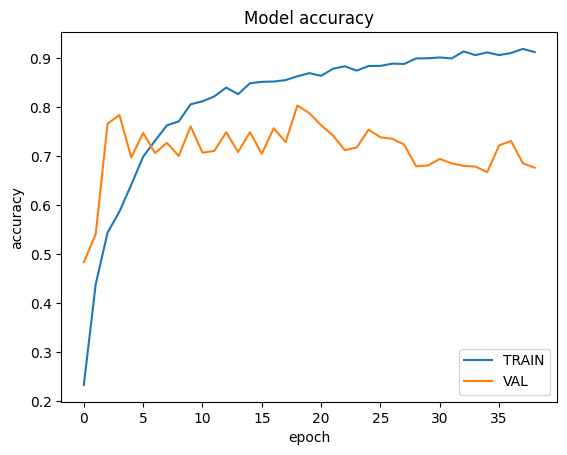

In [67]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [68]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

39/39 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9080


### Draw the confusion matrix to better understand the model performance

39/39 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
                precision    recall  f1-score   support

     Gac chan       0.96      0.99      0.98       182
      Gu lung       1.00      0.88      0.93       179
     Nga lung       1.00      0.56      0.72       187
Nghieng nguoi       0.69      0.99      0.82       187
     Ngoi xom       1.00      0.97      0.98       177
      Ngu gat       0.86      1.00      0.92       108
   Thang lung       0.98      1.00      0.99       197

     accuracy                           0.91      1217
    macro avg       0.93      0.91      0.91      1217
 weighted avg       0.93      0.91      0.90      1217



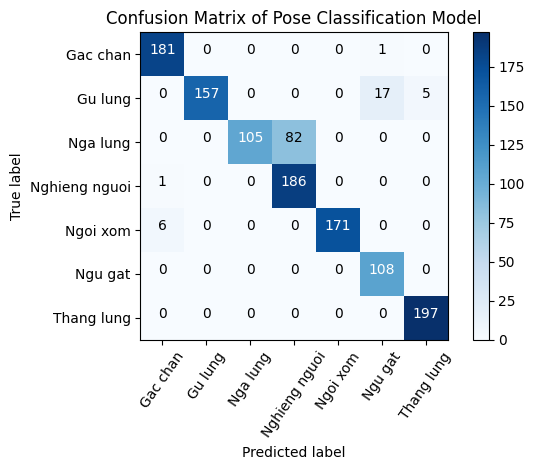

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### (Optional) Investigate incorrect predictions

You can look at the poses from the `TEST` dataset that were incorrectly predicted to see whether the model accuracy can be improved.

Note: This only works if you have run step 1 because you need the pose image files on your local machine to display them.

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


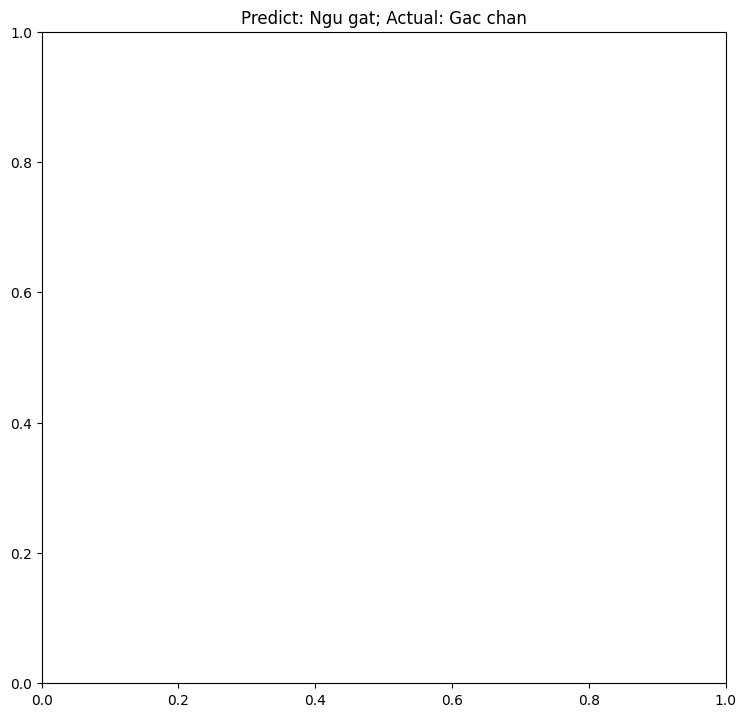

In [70]:
# if is_skip_step_1:
#   raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) 
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# **Part 3: Convert the pose classification model to TensorFlow Lite**

You'll convert the Keras pose classification model to the TensorFlow Lite format so that you can deploy it to mobile apps, web browsers and edge devices. When converting the model, you'll apply [dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) to reduce the pose classification TensorFlow Lite model size by about 4 times with insignificant accuracy loss.

Note: TensorFlow Lite supports multiple quantization schemes. See the [documentation](https://www.tensorflow.org/lite/performance/model_optimization) if you are interested to learn more.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpkvw42hup\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpkvw42hup\assets


Model size: 16KB


Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [ ]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [ ]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9104354971240756


Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

In [ ]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Download the zip archive if running on Colab.
try:
  from google.colab import files
  files.download('pose_classifier.zip')
except:
  pass